# Impacto de Mutações Genéticas na Sobrevida de Pacientes com Câncer de Mama

Este projeto investiga a relação entre mutações genéticas somáticas e a sobrevida global
de pacientes diagnosticados com carcinoma invasivo de mama, utilizando dados do
The Cancer Genome Atlas (TCGA) – PanCancer Atlas.

O objetivo central é avaliar se a presença de mutações em genes driver está associada
a diferenças estatisticamente significativas na sobrevida dos pacientes.


In [ ]:
!pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 4.6 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=dff2a5c1fdac8d12ba468888edb022a0cb51b4cf557492ee8e9c1824dc59612f
  Stored in directory: /root/.cache/pip/wheels/50/37/21/0a719b9d89c635e89ff24bd93b862882ad675279552013b2fb
Successfully built autograd-gamma


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_ind
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Coleta dos dados

In [ ]:
# ==============================================================================
# 1. CARREGAMENTO DOS DADOS (DATA LOADING)
# ==============================================================================
print("Carregando arquivos...")

# data_clinical_patient.txt: Dados do Paciente (Sobrevida, Sexo, Idade)
# 'comment=#' é vital pois o TCGA coloca cabeçalhos explicativos com # no início que quebram o Pandas
df_clinico = pd.read_csv('/content/drive/MyDrive/Biomedicina/Project-two/data_clinical_patient.txt', sep='\t', comment='#')
df_clinco_amostra = pd.read_csv('/content/drive/MyDrive/Biomedicina/Project-two/data_clinical_sample.txt', sep='\t', comment='#')
df_expressao_genica = pd.read_csv('/content/drive/MyDrive/Biomedicina/Project-two/Expressao_genica/data_mrna_seq_v2_rsem.txt', sep='\t', comment='#')
df_expressao_genica2 = pd.read_csv('/content/drive/MyDrive/Biomedicina/Project-two/Expressao_genica/data_mrna_seq_v2_rsem_zscores_ref_all_samples.txt', sep='\t', comment='#')

# data_mutations.txt: Dados Genômicos (Qual gene mudou?)
df_mutacoes = pd.read_csv('/content/drive/MyDrive/Biomedicina/Project-two/data_mutations.txt', sep='\t', comment='#')
df_cna = pd.read_csv('/content/drive/MyDrive/Biomedicina/Project-two/data_cna.txt', sep='\t', comment='#')


Carregando arquivos...


/tmp/ipython-input-524398995.py:14: DtypeWarning: Columns (38,39) have mixed types. Specify dtype option on import or set low_memory=False.
  df_mutacoes = pd.read_csv('/content/drive/MyDrive/Biomedicina/Project-two/data_mutations.txt', sep='\t', comment='#')


In [ ]:
display(df_clinico.head())
display(df_mutacoes.head())
display(df_cna.head())
display(df_clinco_amostra.head())
display(df_expressao_genica.head())
display(df_expressao_genica2.head())

,PATIENT_ID,SUBTYPE,CANCER_TYPE_ACRONYM,OTHER_PATIENT_ID,AGE,SEX,AJCC_PATHOLOGIC_TUMOR_STAGE,AJCC_STAGING_EDITION,DAYS_LAST_FOLLOWUP,DAYS_TO_BIRTH,...,IN_PANCANPATHWAYS_FREEZE,OS_STATUS,OS_MONTHS,DSS_STATUS,DSS_MONTHS,DFS_STATUS,DFS_MONTHS,PFS_STATUS,PFS_MONTHS,GENETIC_ANCESTRY_LABEL
0,TCGA-3C-AAAU,BRCA_LumA,BRCA,6E7D5EC6-A469-467C-B748-237353C23416,55,Female,STAGE X,6TH,4047.0,-20211.0,...,Yes,0:LIVING,133.050597,0:ALIVE OR DEAD TUMOR FREE,133.050597,1:Recurred/Progressed,59.440444,1:PROGRESSION,59.440444,EUR
1,TCGA-3C-AALI,BRCA_Her2,BRCA,55262FCB-1B01-4480-B322-36570430C917,50,Female,STAGE IIB,6TH,4005.0,-18538.0,...,Yes,0:LIVING,131.669790,0:ALIVE OR DEAD TUMOR FREE,131.669790,0:DiseaseFree,131.669790,0:CENSORED,131.669790,AFR
2,TCGA-3C-AALJ,BRCA_LumB,BRCA,427D0648-3F77-4FFC-B52C-89855426D647,62,Female,STAGE IIB,7TH,1474.0,-22848.0,...,Yes,0:LIVING,48.459743,0:ALIVE OR DEAD TUMOR FREE,48.459743,0:DiseaseFree,48.459743,0:CENSORED,48.459743,AFR_ADMIX
3,TCGA-3C-AALK,BRCA_LumA,BRCA,C31900A4-5DCD-4022-97AC-638E86E889E4,52,Female,STAGE IA,7TH,1448.0,-19074.0,...,Yes,0:LIVING,47.604958,0:ALIVE OR DEAD TUMOR FREE,47.604958,NaN,NaN,0:CENSORED,47.604958,AFR
4,TCGA-4H-AAAK,BRCA_LumA,BRCA,6623FC5E-00BE-4476-967A-CBD55F676EA6,50,Female,STAGE IIIA,7TH,348.0,-18371.0,...,Yes,0:LIVING,11.440971,0:ALIVE OR DEAD TUMOR FREE,11.440971,0:DiseaseFree,11.440971,0:CENSORED,11.440971,EUR


,Hugo_Symbol,Entrez_Gene_Id,Center,NCBI_Build,Chromosome,Start_Position,End_Position,Strand,Consequence,Variant_Classification,...,SYMBOL_SOURCE,TREMBL,TSL,UNIPARC,VARIANT_CLASS,all_effects,cDNA_position,n_depth,t_depth,Annotation_Status
0,GATA3,2625.0,.,GRCh37,10,8115874,8115875,+,frameshift_variant,Frame_Shift_Ins,...,HGNC,.,.,UPI000002AA34,insertion,"GATA3,frameshift_variant,p.Pro408AlafsTer99,EN...",1791-1792,26,44,SUCCESS
1,MALAT1,378938.0,.,GRCh37,11,65272906,65272908,+,non_coding_transcript_exon_variant,RNA,...,HGNC,.,.,.,deletion,"MALAT1,non_coding_transcript_exon_variant,,ENS...",7674-7676,139,78,SUCCESS
2,CD248,57124.0,.,GRCh37,11,66082467,66082467,+,missense_variant,Missense_Mutation,...,HGNC,.,.,UPI0000049803,SNV,"CD248,missense_variant,p.Glu678Lys,ENST0000031...",2049,57,69,SUCCESS
3,NAALAD2,10003.0,.,GRCh37,11,89896900,89896900,+,intron_variant,Intron,...,HGNC,"E9PJ53_HUMAN,E9PII2_HUMAN",.,UPI0000031A85,SNV,"NAALAD2,missense_variant,p.Glu372Lys,ENST00000...",.,65,49,SUCCESS
4,CNPY2,10330.0,.,GRCh37,12,56709872,56709872,+,5_prime_UTR_variant,5'UTR,...,HGNC,"H0YI18_HUMAN,F8W1K5_HUMAN,F8VXJ7_HUMAN",.,UPI000004C630,SNV,"CNPY2,5_prime_UTR_variant,,ENST00000273308,;CN...",249,49,27,SUCCESS


,Hugo_Symbol,Entrez_Gene_Id,TCGA-3C-AAAU-01,TCGA-3C-AALI-01,TCGA-3C-AALJ-01,TCGA-3C-AALK-01,TCGA-4H-AAAK-01,TCGA-5L-AAT0-01,TCGA-5T-A9QA-01,TCGA-A1-A0SB-01,...,TCGA-UL-AAZ6-01,TCGA-UU-A93S-01,TCGA-V7-A7HQ-01,TCGA-W8-A86G-01,TCGA-WT-AB41-01,TCGA-WT-AB44-01,TCGA-XX-A899-01,TCGA-XX-A89A-01,TCGA-Z7-A8R5-01,TCGA-Z7-A8R6-01
0,ACAP3,116983.0,0,-1,-1,0,0,0,-1,0,...,0,-1,0,0,-1,-1,0,-1,-1,0
1,ACTRT2,140625.0,0,-1,-1,0,0,0,-1,0,...,0,-1,0,0,-1,-1,0,-1,-1,0
2,AGRN,375790.0,0,-1,-1,0,0,0,-1,0,...,0,-1,0,0,-1,-1,0,-1,-1,0
3,ANKRD65,441869.0,0,-1,-1,0,0,0,-1,0,...,0,-1,0,0,-1,-1,0,-1,-1,0
4,ATAD3A,55210.0,0,-1,-1,0,0,0,-1,0,...,0,-1,0,0,-1,-1,0,-1,-1,0


,PATIENT_ID,SAMPLE_ID,ONCOTREE_CODE,CANCER_TYPE,CANCER_TYPE_DETAILED,TUMOR_TYPE,GRADE,TISSUE_PROSPECTIVE_COLLECTION_INDICATOR,TISSUE_RETROSPECTIVE_COLLECTION_INDICATOR,TISSUE_SOURCE_SITE_CODE,TUMOR_TISSUE_SITE,ANEUPLOIDY_SCORE,SAMPLE_TYPE,MSI_SCORE_MANTIS,MSI_SENSOR_SCORE,SOMATIC_STATUS,TMB_NONSYNONYMOUS,TISSUE_SOURCE_SITE,TBL_SCORE
0,TCGA-3C-AAAU,TCGA-3C-AAAU-01,ILC,Breast Cancer,Breast Invasive Lobular Carcinoma,Infiltrating Lobular Carcinoma,NaN,No,Yes,3C,Breast,19.0,Primary,0.3319,0.55,Matched,0.800000,Columbia University,205.0
1,TCGA-3C-AALI,TCGA-3C-AALI-01,IDC,Breast Cancer,Breast Invasive Ductal Carcinoma,Infiltrating Ductal Carcinoma,NaN,No,Yes,3C,Breast,22.0,Primary,0.3449,0.74,Matched,15.266667,Columbia University,190.0
2,TCGA-3C-AALJ,TCGA-3C-AALJ-01,IDC,Breast Cancer,Breast Invasive Ductal Carcinoma,Infiltrating Ductal Carcinoma,NaN,No,Yes,3C,Breast,13.0,Primary,0.3266,0.31,Matched,0.933333,Columbia University,365.0
3,TCGA-3C-AALK,TCGA-3C-AALK-01,IDC,Breast Cancer,Breast Invasive Ductal Carcinoma,Infiltrating Ductal Carcinoma,NaN,No,Yes,3C,Breast,4.0,Primary,0.3218,0.03,Matched,1.500000,Columbia University,25.0
4,TCGA-4H-AAAK,TCGA-4H-AAAK-01,ILC,Breast Cancer,Breast Invasive Lobular Carcinoma,Infiltrating Lobular Carcinoma,NaN,Yes,No,4H,Breast,7.0,Primary,0.3411,0.01,Matched,0.700000,"Proteogenex, Inc.",36.0


,Hugo_Symbol,Entrez_Gene_Id,TCGA-3C-AAAU-01,TCGA-3C-AALI-01,TCGA-3C-AALJ-01,TCGA-3C-AALK-01,TCGA-4H-AAAK-01,TCGA-5L-AAT0-01,TCGA-5T-A9QA-01,TCGA-A1-A0SB-01,...,TCGA-UL-AAZ6-01,TCGA-UU-A93S-01,TCGA-V7-A7HQ-01,TCGA-W8-A86G-01,TCGA-WT-AB41-01,TCGA-WT-AB44-01,TCGA-XX-A899-01,TCGA-XX-A89A-01,TCGA-Z7-A8R5-01,TCGA-Z7-A8R6-01
0,NaN,100130426,0.0000,0.0000,0.9066,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,NaN,100133144,16.3644,9.2659,11.6228,12.0894,6.8468,3.9889,1.4644,15.3396,...,0.3992,4.3126,0.0000,5.5624,0.0000,0.0000,14.3858,22.3240,2.2638,6.8865
2,UBE2Q2P2,100134869,12.9316,17.3790,9.2294,11.0799,14.4298,13.6090,8.9958,14.3935,...,14.3720,10.8828,3.0792,14.3711,6.3091,3.2580,21.4409,27.2744,7.2933,24.7795
3,HMGB1P1,10357,52.1503,69.7553,154.2970,143.8640,84.2128,114.2570,107.5630,116.3870,...,135.6240,136.1290,29.9974,128.3150,53.6278,42.2643,137.7760,64.1427,85.0461,167.5510
4,NaN,10431,408.0760,563.8930,1360.8300,865.5360,766.3830,807.7430,1420.5000,657.2810,...,1570.1400,2886.4000,1721.8800,697.6740,1245.2700,1877.4200,652.7560,722.7210,1140.2800,1003.5700


,Hugo_Symbol,Entrez_Gene_Id,TCGA-3C-AAAU-01,TCGA-3C-AALI-01,TCGA-3C-AALJ-01,TCGA-3C-AALK-01,TCGA-4H-AAAK-01,TCGA-5L-AAT0-01,TCGA-5T-A9QA-01,TCGA-A1-A0SB-01,...,TCGA-UL-AAZ6-01,TCGA-UU-A93S-01,TCGA-V7-A7HQ-01,TCGA-W8-A86G-01,TCGA-WT-AB41-01,TCGA-WT-AB44-01,TCGA-XX-A899-01,TCGA-XX-A89A-01,TCGA-Z7-A8R5-01,TCGA-Z7-A8R6-01
0,NaN,100130426,-1.7608,-1.7608,1.1240,-1.7608,-1.7608,-1.7608,-1.7608,-1.7608,...,-1.7608,-1.7608,-1.7608,-1.7608,-1.7608,-1.7608,-1.7608,-1.7608,-1.7608,-1.7608
1,NaN,100133144,1.0923,0.3525,0.6434,0.6945,-0.0258,-0.6632,-1.6559,1.0067,...,-2.4527,-0.5747,-2.9255,-0.2774,-2.9255,-2.9255,0.9220,1.5076,-1.2605,-0.0187
2,UBE2Q2P2,100134869,1.0262,1.4779,0.5227,0.7937,1.1927,1.1036,0.4850,1.1889,...,1.1866,0.7669,-0.9761,1.1865,-0.0253,-0.9062,1.8034,2.1801,0.1806,2.0295
3,HMGB1P1,10357,-1.7019,-1.0047,0.9112,0.7417,-0.5515,0.1845,0.0387,0.2291,...,0.5990,0.6080,-3.0160,0.4650,-1.6351,-2.2035,0.6370,-1.2061,-0.5278,1.1108
4,NaN,10431,-2.5301,-1.6372,0.7974,-0.4534,-0.7896,-0.6444,0.9160,-1.2139,...,1.1929,2.8766,1.4480,-1.0492,0.5520,1.6871,-1.2330,-0.9517,0.3085,-0.0445


# Preparação e Tratamento dos dados

In [ ]:
# @title Preparaçao
# Padronizando IDs nas tabelas de expressão e CNA (removendo o sufixo -01, -02, etc.)
def simplify_tcga_id(column_list):
    return [c[:12] if c.startswith("TCGA") else c for c in column_list]

df_expressao_genica2.columns = simplify_tcga_id(df_expressao_genica2.columns)
df_cna.columns = simplify_tcga_id(df_cna.columns)

# 1. Converter OS_STATUS para binário (0: Vivo/Censurado, 1: Óbito)
df_clinico['EVENT'] = df_clinico['OS_STATUS'].apply(lambda x: 1 if '1:DECEASED' in str(x) else 0)

# 2. Garantir que OS_MONTHS e AGE sejam numéricos
df_clinico['OS_MONTHS'] = pd.to_numeric(df_clinico['OS_MONTHS'], errors='coerce')
df_clinico['AGE'] = pd.to_numeric(df_clinico['AGE'], errors='coerce')

# 3. Remover pacientes sem dados de tempo de sobrevida (essencial para Kaplan-Meier)
df_clinico = df_clinico.dropna(subset=['OS_MONTHS'])

# Selecionando genes de interesse (ex: Genes vistos no seu df_mutacoes como GATA3)
genes_interesse = ['GATA3', 'TP53', 'PIK3CA', 'ESR1']

# Transpondo a Expressão Genica
df_exp_t = df_expressao_genica2[df_expressao_genica2['Hugo_Symbol'].isin(genes_interesse)].copy()
df_exp_t = df_exp_t.set_index('Hugo_Symbol').drop(columns='Entrez_Gene_Id').T
df_exp_t.index.name = 'PATIENT_ID'
df_exp_t.columns = [f"EXP_{col}" for col in df_exp_t.columns] # Prefixo para identificar

# Criando um flag de mutação para os genes principais
df_mut_flags = df_mutacoes[df_mutacoes['Hugo_Symbol'].isin(genes_interesse)].copy()
df_mut_matrix = pd.crosstab(df_mut_flags['Tumor_Sample_Barcode'].str[:12], df_mut_flags['Hugo_Symbol'])

# Transformando em 0 e 1 (Presença/Ausência de mutação)
df_mut_matrix = (df_mut_matrix > 0).astype(int)
df_mut_matrix.index.name = 'PATIENT_ID'
df_mut_matrix.columns = [f"MUT_{col}" for col in df_mut_matrix.columns]

In [ ]:
# Unindo Clínica + Mutações + Expressão
df_master = df_clinico.merge(df_mut_matrix, on='PATIENT_ID', how='left')
df_master = df_master.merge(df_exp_t, on='PATIENT_ID', how='left')

# Preencher mutações vazias com 0 (pacientes que não apareceram na df_mutacoes não tinham mutações reportadas)
cols_mut = [c for c in df_master.columns if c.startswith('MUT_')]
df_master[cols_mut] = df_master[cols_mut].fillna(0)

print(f"Dataset preparado! Total de pacientes: {len(df_master)}")
display(df_master.head())

Dataset preparado! Total de pacientes: 1084


,PATIENT_ID,SUBTYPE,CANCER_TYPE_ACRONYM,OTHER_PATIENT_ID,AGE,SEX,AJCC_PATHOLOGIC_TUMOR_STAGE,AJCC_STAGING_EDITION,DAYS_LAST_FOLLOWUP,DAYS_TO_BIRTH,...,GENETIC_ANCESTRY_LABEL,EVENT,MUT_ESR1,MUT_GATA3,MUT_PIK3CA,MUT_TP53,EXP_ESR1,EXP_GATA3,EXP_PIK3CA,EXP_TP53
0,TCGA-3C-AAAU,BRCA_LumA,BRCA,6E7D5EC6-A469-467C-B748-237353C23416,55,Female,STAGE X,6TH,4047.0,-20211.0,...,EUR,0,0.0,1.0,0.0,0.0,0.0302,0.5553,-0.0609,-0.0890
1,TCGA-3C-AALI,BRCA_Her2,BRCA,55262FCB-1B01-4480-B322-36570430C917,50,Female,STAGE IIB,6TH,4005.0,-18538.0,...,AFR,0,0.0,0.0,0.0,1.0,-1.7359,0.0952,-0.8412,-2.1092
2,TCGA-3C-AALJ,BRCA_LumB,BRCA,427D0648-3F77-4FFC-B52C-89855426D647,62,Female,STAGE IIB,7TH,1474.0,-22848.0,...,AFR_ADMIX,0,0.0,1.0,0.0,0.0,0.3790,0.3202,-1.5863,-0.2097
3,TCGA-3C-AALK,BRCA_LumA,BRCA,C31900A4-5DCD-4022-97AC-638E86E889E4,52,Female,STAGE IA,7TH,1448.0,-19074.0,...,AFR,0,0.0,0.0,1.0,0.0,-0.1191,0.2101,-0.8173,-0.0499
4,TCGA-4H-AAAK,BRCA_LumA,BRCA,6623FC5E-00BE-4476-967A-CBD55F676EA6,50,Female,STAGE IIIA,7TH,348.0,-18371.0,...,EUR,0,0.0,0.0,0.0,0.0,0.2414,0.5420,-0.3844,0.0263


In [ ]:
df_master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1084 entries, 0 to 1083
Data columns (total 47 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   PATIENT_ID                                  1084 non-null   object 
 1   SUBTYPE                                     981 non-null    object 
 2   CANCER_TYPE_ACRONYM                         1084 non-null   object 
 3   OTHER_PATIENT_ID                            1084 non-null   object 
 4   AGE                                         1084 non-null   int64  
 5   SEX                                         1084 non-null   object 
 6   AJCC_PATHOLOGIC_TUMOR_STAGE                 1079 non-null   object 
 7   AJCC_STAGING_EDITION                        944 non-null    object 
 8   DAYS_LAST_FOLLOWUP                          980 non-null    float64
 9   DAYS_TO_BIRTH                               1069 non-null   float64
 10  DAYS_TO_INIT

# Análise exploratória dos dados

Pearson
                 AGE  OS_MONTHS  EXP_ESR1  EXP_GATA3  EXP_PIK3CA  EXP_TP53
AGE         1.000000  -0.158763  0.222030   0.098557   -0.105852 -0.029916
OS_MONTHS  -0.158763   1.000000 -0.013080   0.016577    0.005560  0.017471
EXP_ESR1    0.222030  -0.013080  1.000000   0.835003   -0.079795  0.065480
EXP_GATA3   0.098557   0.016577  0.835003   1.000000   -0.166796  0.084145
EXP_PIK3CA -0.105852   0.005560 -0.079795  -0.166796    1.000000 -0.058293
EXP_TP53   -0.029916   0.017471  0.065480   0.084145   -0.058293  1.000000
Spearman
                 AGE  OS_MONTHS  EXP_ESR1  EXP_GATA3  EXP_PIK3CA  EXP_TP53
AGE         1.000000  -0.173517  0.345102   0.110234   -0.086205 -0.036825
OS_MONTHS  -0.173517   1.000000 -0.041014   0.033571    0.039942  0.042746
EXP_ESR1    0.345102  -0.041014  1.000000   0.720066   -0.031958 -0.044678
EXP_GATA3   0.110234   0.033571  0.720066   1.000000   -0.180564  0.013600
EXP_PIK3CA -0.086205   0.039942 -0.031958  -0.180564    1.000000 -0.059585
EXP_TP53

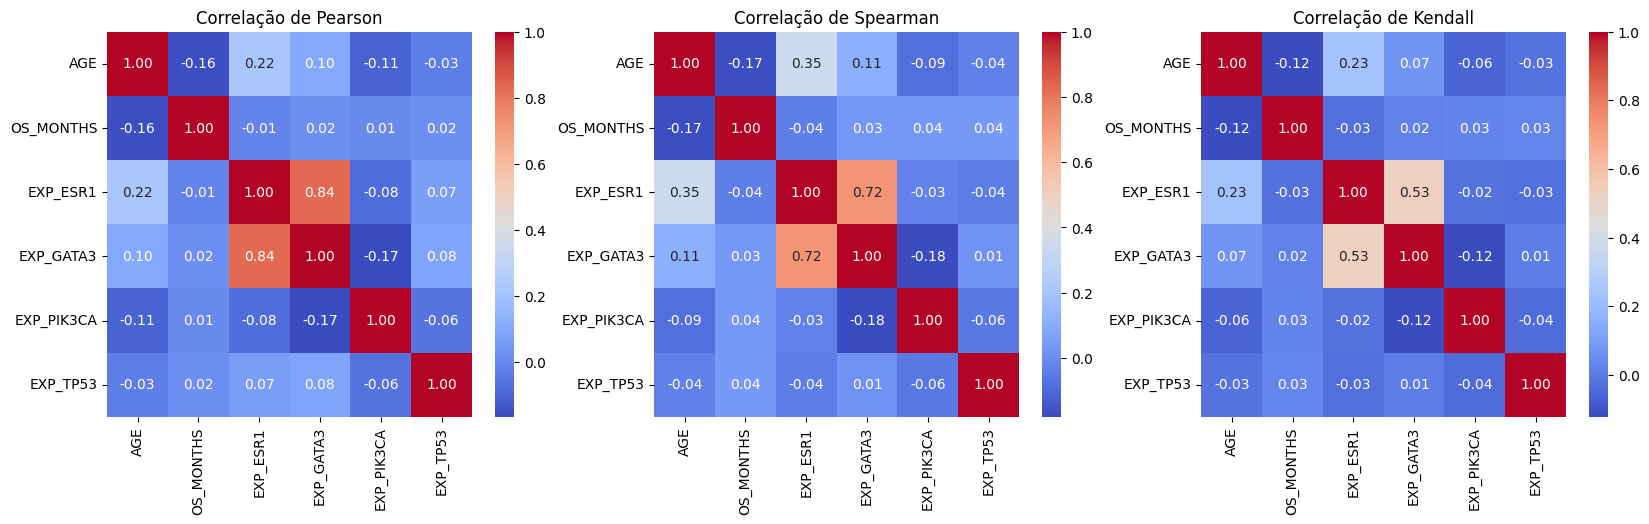

In [ ]:
# @title Matriz de Correlações Multimodais
# Selecionando apenas colunas numéricas de interesse (Expressão e Sobrevida)
cols_analise = ['AGE', 'OS_MONTHS', 'EXP_ESR1', 'EXP_GATA3', 'EXP_PIK3CA', 'EXP_TP53']
df_num = df_master[cols_analise]

methods = ['pearson', 'spearman', 'kendall']
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for i, method in enumerate(methods):
    corr = df_num.corr(method=method)
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[i])
    axes[i].set_title(f'Correlação de {method.capitalize()}')


#Exibiçao com print
print("Pearson")
print(df_num.corr(method='pearson'))
print(80*"=")
print("Spearman")
print(df_num.corr(method='spearman'))
print(80*"=")
print("Kendall")
print(df_num.corr(method='kendall'))

Pearson
                 AGE  OS_MONTHS  MUT_ESR1  MUT_GATA3  MUT_PIK3CA  MUT_TP53
AGE         1.000000  -0.158763  0.046431  -0.083342    0.072499 -0.080809
OS_MONTHS  -0.158763   1.000000 -0.055577  -0.027715   -0.015286  0.018394
MUT_ESR1    0.046431  -0.055577  1.000000   0.052993    0.053591 -0.030709
MUT_GATA3  -0.083342  -0.027715  0.052993   1.000000   -0.067699 -0.176135
MUT_PIK3CA  0.072499  -0.015286  0.053591  -0.067699    1.000000 -0.122815
MUT_TP53   -0.080809   0.018394 -0.030709  -0.176135   -0.122815  1.000000
Spearman
                 AGE  OS_MONTHS  MUT_ESR1  MUT_GATA3  MUT_PIK3CA  MUT_TP53
AGE         1.000000  -0.173517  0.042889  -0.087087    0.070483 -0.084900
OS_MONTHS  -0.173517   1.000000 -0.072769  -0.029729    0.004007  0.006400
MUT_ESR1    0.042889  -0.072769  1.000000   0.052993    0.053591 -0.030709
MUT_GATA3  -0.087087  -0.029729  0.052993   1.000000   -0.067699 -0.176135
MUT_PIK3CA  0.070483   0.004007  0.053591  -0.067699    1.000000 -0.122815
MUT_TP53

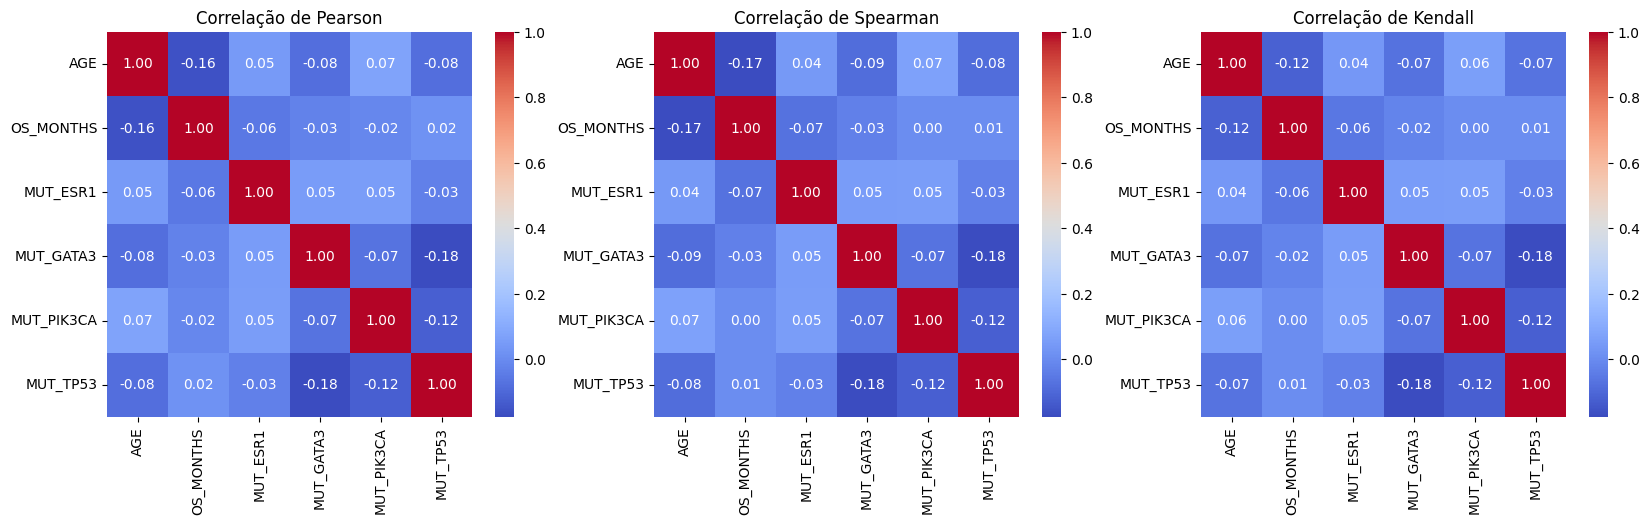

In [ ]:
# @title Matriz de Correlações Multimodais ii
# Selecionando apenas colunas numéricas de interesse (Expressão e Sobrevida)
cols_analise = ['AGE', 'OS_MONTHS', 'MUT_ESR1', 'MUT_GATA3', 'MUT_PIK3CA', 'MUT_TP53']
df_num = df_master[cols_analise]

methods = ['pearson', 'spearman', 'kendall']
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for i, method in enumerate(methods):
    corr = df_num.corr(method=method)
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", ax=axes[i])
    axes[i].set_title(f'Correlação de {method.capitalize()}')


#Exibiçao com print
print("Pearson")
print(df_num.corr(method='pearson'))
print(80*"=")
print("Spearman")
print(df_num.corr(method='spearman'))
print(80*"=")
print("Kendall")
print(df_num.corr(method='kendall'))

In [ ]:
# @title Análise de Causalidade e Diferença de Médias (ANOVA/T-Test)
from scipy.stats import ttest_ind, f_oneway

# Exemplo: Impacto da Mutação TP53 na Expressão de ESR1
mut_col = 'MUT_TP53'
exp_target = 'EXP_ESR1'

group_mut = df_master[df_master[mut_col] == 1][exp_target].dropna()
group_wt = df_master[df_master[mut_col] == 0][exp_target].dropna()

t_stat, p_val = ttest_ind(group_mut, group_wt)
print(f"Teste T ({mut_col} -> {exp_target}): P-valor = {p_val:.4f}")

# ANOVA por Subtipo de Câncer
subtipos = df_master['SUBTYPE'].dropna().unique()
grupos_anova = [df_master[df_master['SUBTYPE'] == s]['EXP_ESR1'].dropna() for s in subtipos]
f_stat, p_anova = f_oneway(*grupos_anova)
print(f"ANOVA (Subtipo -> EXP_ESR1): P-valor = {p_anova:.4f}")

Teste T (MUT_TP53 -> EXP_ESR1): P-valor = 0.0000
ANOVA (Subtipo -> EXP_ESR1): P-valor = 0.0000


In [ ]:
# @title Regressão Linear e Logística
import statsmodels.api as sm

# Regressão Linear: O que afeta o tempo de sobrevida?
X = df_master[['AGE', 'EXP_ESR1', 'EXP_TP53']].dropna()
y = df_master.loc[X.index, 'OS_MONTHS']
X = sm.add_constant(X) # Adiciona o intercepto

modelo_lin = sm.OLS(y, X).fit()
print(modelo_lin.summary())

# Regressão Logística: Mutações aumentam a chance de óbito?
X_log = df_master[['MUT_TP53', 'MUT_PIK3CA', 'AGE']].dropna()
y_log = df_master.loc[X_log.index, 'EVENT']
X_log = sm.add_constant(X_log)

modelo_log = sm.Logit(y_log, X_log).fit()
print(modelo_log.summary())

                            OLS Regression Results                            
Dep. Variable:              OS_MONTHS   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     9.463
Date:                Sat, 27 Dec 2025   Prob (F-statistic):           3.57e-06
Time:                        19:36:21   Log-Likelihood:                -5495.2
No. Observations:                1082   AIC:                         1.100e+04
Df Residuals:                    1078   BIC:                         1.102e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         69.2479      5.507     12.574      0.0

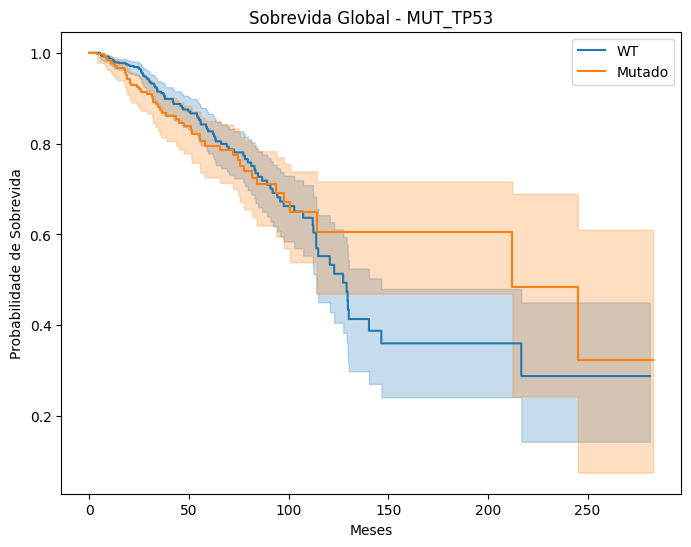

Log-rank p-valor: 7.5315e-01


<lifelines.CoxPHFitter: fitted with 1084 total observations, 933 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'EVENT'
      baseline estimation = breslow
   number of observations = 1084
number of events observed = 151
   partial log-likelihood = -853.37
         time fit was run = 2025-12-27 19:36:21 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
MUT_TP53   0.05      1.06      0.17           -0.28            0.39                0.75                1.48

           cmp to    z    p  -log2(p)
covariate                            
MUT_TP53     0.00 0.31 0.75      0.41
---
Concordance = 0.54
Partial AIC = 1708.75
log-likelihood ratio test = 0.10 on 1 df
-log2(p) of ll-ratio test = 0.41

In [ ]:
# @title  ANÁLISES DE SOBREVIDA (ASSOCIAÇÃO DIRETA)
time_col = 'OS_MONTHS'        # ou DAYS_TO_DEATH
event_col = 'EVENT'       # 1 = óbito, 0 = censurado

# Mutação exemplo
mut_gene = 'MUT_TP53'         # 1 = mutado, 0 = WT

# Outras variáveis comuns
age_col = 'AGE'
subtype_col = 'SUBTYPE'
stage_col = 'AJCC_PATHOLOGIC_TUMOR_STAGE'



from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter


kmf = KaplanMeierFitter()

plt.figure(figsize=(8,6))

for label, group in [('WT', 0), ('Mutado', 1)]:
    mask = df_master[mut_gene] == group
    kmf.fit(
        durations=df_master.loc[mask, time_col],
        event_observed=df_master.loc[mask, 'EVENT'],
        label=label
    )
    kmf.plot_survival_function()

# Log-rank
group_mut = df_master[df_master[mut_gene] == 1]
group_wt  = df_master[df_master[mut_gene] == 0]

lr = logrank_test(
    group_mut[time_col], group_wt[time_col],
    event_observed_A=group_mut['EVENT'],
    event_observed_B=group_wt['EVENT']
)

plt.title(f"Sobrevida Global - {mut_gene}")
plt.xlabel("Meses")
plt.ylabel("Probabilidade de Sobrevida")
plt.show()

print(f"Log-rank p-valor: {lr.p_value:.4e}")



df_cox = df_master[[time_col, 'EVENT', mut_gene]].dropna()

cph = CoxPHFitter()
cph.fit(df_cox, duration_col=time_col, event_col='EVENT')

cph.print_summary()

In [ ]:
# @title MODELO DE COX MULTIVARIADO (EFEITO INDEPENDENTE)

covariates = [
    mut_gene,
    age_col,
    'EXP_ESR1',        # se existir
]

# Use 'EVENT' column instead of event_col ('OS_STATUS') for numerical event status
df_multi = df_master[[time_col, 'EVENT'] + covariates].dropna()

cph_multi = CoxPHFitter()
cph_multi.fit(df_multi, duration_col=time_col, event_col='EVENT')

cph_multi.print_summary()

# Use 'EVENT' column instead of event_col ('OS_STATUS') for numerical event status
df_inter = df_master[[time_col, 'EVENT', mut_gene, subtype_col]].dropna()

df_inter = pd.get_dummies(df_inter, columns=[subtype_col])

# Exemplo: interação com um subtipo específico
interaction_col = f"{mut_gene}_x_Basal"
df_inter[interaction_col] = df_inter[mut_gene] * df_inter.filter(like='Basal').iloc[:,0]

if 'SUBTYPE_BRCA_LumA' in df_inter.columns:
    df_inter_for_cox_inter = df_inter.drop(columns=['SUBTYPE_BRCA_LumA'])
else:
    df_inter_for_cox_inter = df_inter.copy()

cph_inter = CoxPHFitter()
cph_inter.fit(df_inter_for_cox_inter, duration_col=time_col, event_col='EVENT')

cph_inter.print_summary()

<lifelines.CoxPHFitter: fitted with 1082 total observations, 931 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'EVENT'
      baseline estimation = breslow
   number of observations = 1082
number of events observed = 151
   partial log-likelihood = -839.23
         time fit was run = 2025-12-27 19:36:22 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
MUT_TP53   0.07      1.08      0.22           -0.36            0.51                0.70                1.66
AGE        0.03      1.04      0.01            0.02            0.05                1.02                1.05
EXP_ESR1  -0.10      0.91      0.11           -0.31            0.11                0.73                1.12

           cmp to     z      p  -log2(p)
covariate                               
MUT_TP53     0.00  0.33   0.74      0.43
AGE          0.00  5.34 <0.005     23.37
EXP_ESR1     0.00 -0.94   0.35      1.52
---
Concordance = 0.65
Partial AIC = 1684.46
log-likelihood ratio test = 28.26 on 3 df
-log2(p) of ll-ratio test = 18.25

<lifelines.CoxPHFitter: fitted with 981 total observations, 849 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'EVENT'
      baseline estimation = breslow
   number of observations = 981
number of events observed = 132
   partial log-likelihood = -727.27
         time fit was run = 2025-12-27 19:36:22 UTC

---
                     coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                            
MUT_TP53             0.03      1.03      0.25           -0.47            0.53                0.63                1.70
SUBTYPE_BRCA_Basal  -0.41      0.66      1.01           -2.39            1.57                0.09                4.81
SUBTYPE_BRCA_Her2    0.72      2.05      0.35            0.04            1.40                1.04                4.05
SUBTYPE_BRCA_LumB    0.53      1.69      0.23            0.07            0.98                1.07                2.67
SUBTYPE_BRCA_Normal  0.50      1.65      0.41           -0.29            1.30                0.75                3.67
MUT_TP53_x_Basal     0.46      1.58      1.06           -1.61            2.53                0.20               12.55

                     cmp to     z    p  -log2(p)
covariate                                       
MUT_TP53               0.00  0.12 0.90      0.15
SUBTYPE_BRCA_Basal     0.00 -0.40 0.69      0.54
SUBTYPE_BRCA_Her2      0.00  2.08 0.04      4.74
SUBTYPE_BRCA_LumB      0.00  2.25 0.02      5.37
SUBTYPE_BRCA_Normal    0.00  1.24 0.21      2.22
MUT_TP53_x_Basal       0.00  0.43 0.67      0.59
---
Concordance = 0.60
Partial AIC = 1466.54
log-likelihood ratio test = 10.54 on 6 df
-log2(p) of ll-ratio test = 3.27

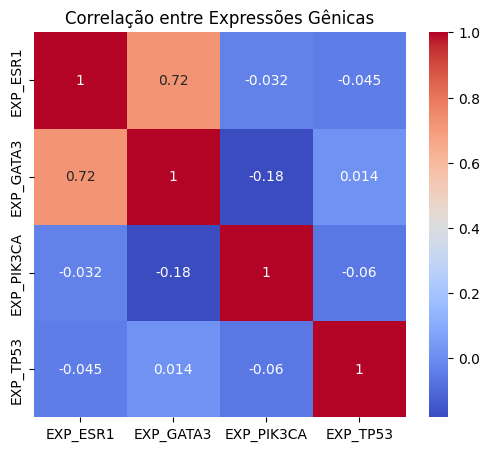

Mann-Whitney U p-valor: 4.0927e-55


In [ ]:
# @title CORRELAÇÕES MOLECULARES
#Correlação entre Expressões Gênicas
from scipy.stats import spearmanr
import seaborn as sns

genes = ['EXP_ESR1', 'EXP_GATA3', 'EXP_PIK3CA', 'EXP_TP53']

df_genes = df_master[genes].dropna()

corr = df_genes.corr(method='spearman')

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlação entre Expressões Gênicas")
plt.show()

# Expressão × Mutação (Teste Estatístico)
from scipy.stats import mannwhitneyu

group_mut = df_master[df_master[mut_gene] == 1]['EXP_ESR1'].dropna()
group_wt  = df_master[df_master[mut_gene] == 0]['EXP_ESR1'].dropna()

u, p = mannwhitneyu(group_mut, group_wt, alternative='two-sided')

print(f"Mann-Whitney U p-valor: {p:.4e}")


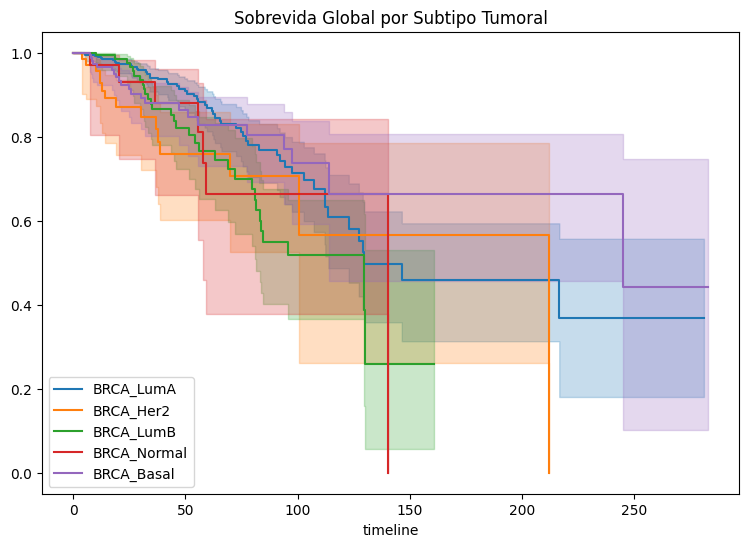

In [ ]:
# @title ANÁLISES ESTRATIFICADAS
plt.figure(figsize=(9,6))

for subtype in df_master[subtype_col].dropna().unique():
    mask = df_master[subtype_col] == subtype
    kmf.fit(
        df_master.loc[mask, time_col],
        df_master.loc[mask, 'EVENT'],
        label=subtype
    )
    kmf.plot_survival_function()

plt.title("Sobrevida Global por Subtipo Tumoral")
plt.show()


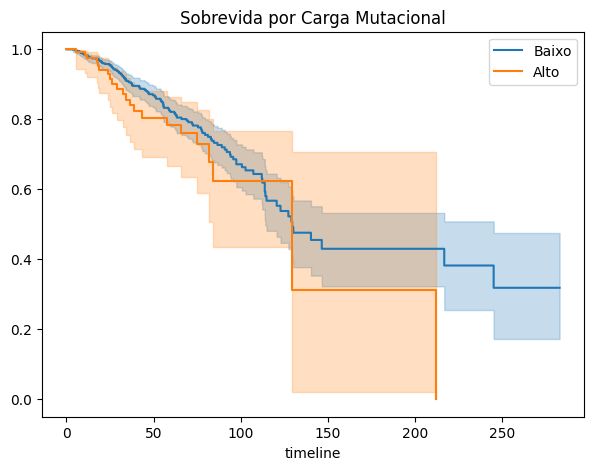

In [ ]:
# @title Carga Mutacional (TMB simples)
# Exemplo: colunas binárias de mutação
mut_cols = [c for c in df_master.columns if c.startswith('MUT_')]

df_master['TMB'] = df_master[mut_cols].sum(axis=1)

df_master['TMB_CAT'] = pd.qcut(df_master['TMB'], q=2, labels=['Baixo', 'Alto'])

df_tmb = df_master[[time_col, event_col, 'TMB_CAT']].dropna()

plt.figure(figsize=(7,5))
for cat in ['Baixo', 'Alto']:
    mask = df_tmb['TMB_CAT'] == cat
    kmf.fit(df_tmb.loc[mask, time_col], df_tmb.loc[mask, event_col], label=cat)
    kmf.plot_survival_function()

plt.title("Sobrevida por Carga Mutacional")
plt.show()

In [ ]:
# @title COOCORRÊNCIA DE MUTAÇÕES
from scipy.stats import chi2_contingency

gene_a = 'MUT_TP53'
gene_b = 'MUT_PIK3CA'

table = pd.crosstab(df_master[gene_a], df_master[gene_b])
chi2, p, _, _ = chi2_contingency(table)

print(table)
print(f"Qui-quadrado p-valor: {p:.4e}")


MUT_PIK3CA  0.0  1.0
MUT_TP53            
0.0         470  266
1.0         265   83
Qui-quadrado p-valor: 7.0692e-05


In [ ]:
# @title MEDIAÇÃO (MUTAÇÃO → EXPRESSÃO → SOBREVIDA)
import statsmodels.api as sm

# 1. Mutação → Expressão
X1 = sm.add_constant(df_master[mut_gene])
y1 = df_master['EXP_ESR1']
model1 = sm.OLS(y1, X1, missing='drop').fit()

# 2. Expressão → Sobrevida (Cox)
df_med = df_master[[time_col, event_col, 'EXP_ESR1']].dropna()
cph_med = CoxPHFitter()
cph_med.fit(df_med, duration_col=time_col, event_col=event_col)

model1.summary(), cph_med.summary


(<class 'statsmodels.iolib.summary.Summary'>
 """
                             OLS Regression Results                            
 Dep. Variable:               EXP_ESR1   R-squared:                       0.293
 Model:                            OLS   Adj. R-squared:                  0.292
 Method:                 Least Squares   F-statistic:                     447.9
 Date:                Sat, 27 Dec 2025   Prob (F-statistic):           1.95e-83
 Time:                        19:36:23   Log-Likelihood:                -1347.6
 No. Observations:                1082   AIC:                             2699.
 Df Residuals:                    1080   BIC:                             2709.
 Df Model:                           1                                         
 Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
 ---------------------------------------------------------------------

In [ ]:
# @title MODELO PREDITIVO DE RISCO (COX PENALIZADO)
from lifelines import CoxPHFitter

features = mut_cols + ['EXP_ESR1', age_col]

df_pred = df_master[[time_col, event_col] + features].dropna()

cph_lasso = CoxPHFitter(penalizer=0.1)
cph_lasso.fit(df_pred, duration_col=time_col, event_col=event_col)

cph_lasso.print_summary()


<lifelines.CoxPHFitter: fitted with 1082 total observations, 931 right-censored observations>
             duration col = 'OS_MONTHS'
                event col = 'EVENT'
                penalizer = 0.1
                 l1 ratio = 0.0
      baseline estimation = breslow
   number of observations = 1082
number of events observed = 151
   partial log-likelihood = -845.09
         time fit was run = 2025-12-27 19:36:23 UTC

---
            coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                   
MUT_ESR1    0.43      1.54      0.60           -0.74            1.60                0.48                4.93
MUT_GATA3   0.14      1.16      0.20           -0.24            0.53                0.79                1.70
MUT_PIK3CA  0.03      1.03      0.14           -0.24            0.29                0.79                1.34
MUT_TP53    0.07      1.07      0.14           -0.21            0.35                0.81                1.41
EXP_ESR1   -0.04      0.97      0.07           -0.17            0.10                0.84                1.10
AGE         0.02      1.02      0.00            0.01            0.03                1.01                1.03

            cmp to     z      p  -log2(p)
covariate                                
MUT_ESR1      0.00  0.72   0.47      1.08
MUT_GATA3     0.00  0.74   0.46      1.12
MUT_PIK3CA    0.00  0.21   0.83      0.27
MUT_TP53      0.00  0.47   0.64      0.64
EXP_ESR1      0.00 -0.52   0.60      0.73
AGE           0.00  3.98 <0.005     13.81
---
Concordance = 0.65
Partial AIC = 1702.19
log-likelihood ratio test = 16.53 on 6 df
-log2(p) of ll-ratio test = 6.48

# Análises mais profundas

In [ ]:
# Verificando a saúde dos dados de sobrevida
print(f"Total de pacientes: {len(df_master)}")
print(f"Pacientes com óbito (EVENT=1): {df_master['EVENT'].sum()}")
print(f"Pacientes com meses de sobrevida válidos: {df_master['OS_MONTHS'].notnull().sum()}")

# Testando uma variável específica para ver o que sobra após o dropna
feature_teste = 'EXP_TP53'
df_teste = df_master[[feature_teste, 'OS_MONTHS', 'EVENT']].dropna()
print(f"Linhas restantes para {feature_teste}: {len(df_teste)}")

# 1. Verificar se existem óbitos (se EVENT for sempre 0, o Cox não funciona)
print(f"Contagem de Eventos:\n{df_master['EVENT'].value_counts()}")

# 2. Verificar se há tempos zero ou negativos (O Cox falha com tempo <= 0)
invalid_times = df_master[df_master['OS_MONTHS'] <= 0]
print(f"Pacientes com tempo de sobrevida <= 0: {len(invalid_times)}")

# 3. Verificar a variabilidade das features (Expressões e Mutações)
features = [c for c in df_master.columns if c.startswith(('MUT_', 'EXP_'))]
constant_features = [f for f in features if df_master[f].nunique() <= 1]
print(f"Features constantes (sem variabilidade): {len(constant_features)}")

Total de pacientes: 1084
Pacientes com óbito (EVENT=1): 151
Pacientes com meses de sobrevida válidos: 1084
Linhas restantes para EXP_TP53: 1082
Contagem de Eventos:
EVENT
0    933
1    151
Name: count, dtype: int64
Pacientes com tempo de sobrevida <= 0: 13
Features constantes (sem variabilidade): 0


In [ ]:
# 1. Filtro de Integridade
df_final = df_master[df_master['OS_MONTHS'] > 0].copy() # Remove tempos <= 0
if 'WEIGHT' in df_final.columns:
    df_final = df_final.drop(columns=['WEIGHT'])

# 2. Tratamento de Nulos para Machine Learning
# Mutações vazias tratamos como 0 (Não mutado)
cols_mut = [c for c in df_final.columns if c.startswith('MUT_')]
df_final[cols_mut] = df_final[cols_mut].fillna(0)

# Expressões vazias tratamos pela mediana do gene
cols_exp = [c for c in df_final.columns if c.startswith('EXP_')]
df_final[cols_exp] = df_final[cols_exp].fillna(df_final[cols_exp].median())

print(f"Dados prontos! Pacientes válidos: {len(df_final)} | Óbitos: {df_final['EVENT'].sum()}")

Dados prontos! Pacientes válidos: 1071 | Óbitos: 151


In [ ]:
# @title Screening de Risco (Systematic Univariate Cox)
from lifelines import CoxPHFitter

features = [c for c in df_final.columns if c.startswith(('MUT_', 'EXP_'))]
resultados_sobrevida = []

for f in features:
    df_temp = df_final[[f, 'OS_MONTHS', 'EVENT']]
    # Exigimos que pelo menos 10 pacientes tenham o evento para o gene ser testado
    if df_temp['EVENT'].sum() >= 10:
        cph = CoxPHFitter(penalizer=0.1)
        try:
            cph.fit(df_temp, duration_col='OS_MONTHS', event_col='EVENT')
            res = cph.summary[['exp(coef)', 'p']].copy()
            res['feature'] = f
            res['Risco'] = res['exp(coef)'].apply(lambda x: 'Aumenta Risco' if x > 1 else 'Protetor')
            resultados_sobrevida.append(res)
        except:
            continue

df_ranking_risco = pd.concat(resultados_sobrevida).sort_values(by='p')
print("Top 10 Biomarcadores de Risco:")
display(df_ranking_risco.head(10))

Top 10 Biomarcadores de Risco:


,exp(coef),p,feature,Risco
covariate,,,,
EXP_PIK3CA,1.114702,0.096301,EXP_PIK3CA,Aumenta Risco
EXP_TP53,1.054659,0.382830,EXP_TP53,Aumenta Risco
MUT_ESR1,1.556139,0.467661,MUT_ESR1,Aumenta Risco
EXP_GATA3,0.962128,0.528608,EXP_GATA3,Protetor
MUT_GATA3,1.091897,0.647445,MUT_GATA3,Aumenta Risco
MUT_TP53,1.032425,0.809450,MUT_TP53,Aumenta Risco
MUT_PIK3CA,1.032296,0.812439,MUT_PIK3CA,Aumenta Risco
EXP_ESR1,0.999660,0.995725,EXP_ESR1,Protetor


In [ ]:
from scipy.stats import mannwhitneyu

relacoes = []
for mut in cols_mut:
    for exp in cols_exp:
        g1 = df_final[df_final[mut] == 1][exp]
        g0 = df_final[df_final[mut] == 0][exp]

        if len(g1) > 5 and len(g0) > 5:
            stat, p = mannwhitneyu(g1, g0)
            diff = g1.mean() - g0.mean()
            relacoes.append({'Mutação': mut, 'Gene_Expressão': exp, 'P-valor': p, 'Diferença_Média': diff})

df_causalidade = pd.DataFrame(relacoes).sort_values(by='P-valor')
print("\nAssociações Fortes (Mutação -> Alteração de Expressão):")
display(df_causalidade[df_causalidade['P-valor'] < 0.05].head(10))


Associações Fortes (Mutação -> Alteração de Expressão):


,Mutação,Gene_Expressão,P-valor,Diferença_Média
13,MUT_TP53,EXP_GATA3,3.826330e-69,-1.146073
12,MUT_TP53,EXP_ESR1,1.414309e-54,-1.162034
5,MUT_GATA3,EXP_GATA3,1.627076e-28,0.787104
14,MUT_TP53,EXP_PIK3CA,4.448964e-10,0.416144
4,MUT_GATA3,EXP_ESR1,6.633175e-09,0.612147
8,MUT_PIK3CA,EXP_ESR1,5.725351e-07,0.452903
9,MUT_PIK3CA,EXP_GATA3,2.633069e-04,0.405525
7,MUT_GATA3,EXP_TP53,1.892397e-02,0.256913


In [ ]:
# @title TRIAGEM DE RISCO POR KAPLAN–MEIER + LOG-RANK
# (Abordagem robusta para baixo número de eventos)
# ==============================================================================

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
print("Iniciando triagem por Kaplan–Meier...")

# A. Limpeza Profunda (copiado de p8pIMB5DEUF7 para tornar esta célula robusta)
# Criamos uma cópia apenas com o necessário
df_cox_final = df_master.copy()

# O Cox falha se o tempo for 0. Adicionamos um pequeno valor (jitter)
df_cox_final['OS_MONTHS'] = df_cox_final['OS_MONTHS'].apply(lambda x: x if x > 0 else 0.001)


# ------------------------------------------------------------------------------
# 4.1 Seleção de features com frequência mínima de mutação
# ------------------------------------------------------------------------------
min_pacientes = 30  # limiar conservador e defensável

# Define colunas de mutação aqui para este propósito de triagem específico
mut_cols = [c for c in df_cox_final.columns if c.startswith('MUT_')]

features_km = [
    f for f in mut_cols  # Usa mut_cols como as features para triagem KM
    if df_cox_final[f].sum() >= min_pacientes
]

print(f"Features elegíveis para KM (>= {min_pacientes} pacientes mutados): {len(features_km)}")

# ------------------------------------------------------------------------------
# 4.2 Loop Kaplan–Meier + Log-rank
# ------------------------------------------------------------------------------
km_results = []

for feature in features_km:
    try:
        # Garante que df_tmp não está vazio após dropna
        df_tmp = df_cox_final[[feature, 'OS_MONTHS', 'EVENT']].dropna()
        if df_tmp.empty:
            print(f"Skipping {feature}: df_tmp is empty after dropna.")
            continue

        grupo_mut = df_tmp[df_tmp[feature] == 1]
        grupo_wt  = df_tmp[df_tmp[feature] == 0]

        # Verificação mínima de eventos em ambos os grupos
        if grupo_mut['EVENT'].sum() < 5 or grupo_wt['EVENT'].sum() < 5:
            print(f"Skipping {feature}: Eventos insuficientes em um ou ambos os grupos ({grupo_mut['EVENT'].sum()} mut, {grupo_wt['EVENT'].sum()} wt).")
            continue
        if len(grupo_mut) == 0 or len(grupo_wt) == 0:
            print(f"Skipping {feature}: Um dos grupos está vazio após a filtragem.")
            continue


        # Log-rank test
        lr = logrank_test(
            grupo_mut['OS_MONTHS'],
            grupo_wt['OS_MONTHS'],
            event_observed_A=grupo_mut['EVENT'],
            event_observed_B=grupo_wt['EVENT']
        )

        km_results.append({
            'feature': feature,
            'n_mut': len(grupo_mut),
            'n_wt': len(grupo_wt),
            'events_mut': grupo_mut['EVENT'].sum(),
            'events_wt': grupo_wt['EVENT'].sum(),
            'p_value': lr.p_value
        })

    except Exception as e:
        print(f"Error in KM/Log-rank for feature {feature}: {e}")
        continue

# ------------------------------------------------------------------------------
# 4.3 Resultados organizados
# ------------------------------------------------------------------------------
df_km_results = (
    pd.DataFrame(km_results)
    .sort_values('p_value')
    .reset_index(drop=True)
)

print(f"Total de features avaliadas com sucesso: {df_km_results.shape[0]}")

display(df_km_results.head(10))


Iniciando triagem por Kaplan–Meier...
Features elegíveis para KM (>= 30 pacientes mutados): 3
Total de features avaliadas com sucesso: 3


,feature,n_mut,n_wt,events_mut,events_wt,p_value
0,MUT_GATA3,131,953,19,132,0.544575
1,MUT_TP53,348,736,52,99,0.753150
2,MUT_PIK3CA,349,735,48,103,0.754452


<Axes: title={'center': 'Variáveis que melhor explicam o desfecho clínico'}>

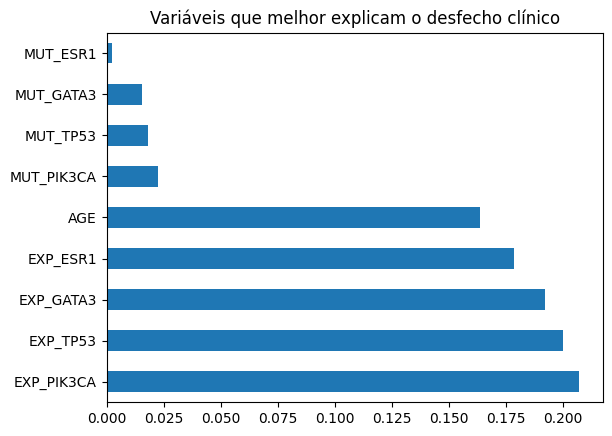

In [ ]:
# @title Ranking de Importância das Variáveis para Predição de Desfecho

from sklearn.ensemble import RandomForestClassifier

# Selecionamos APENAS as colunas numéricas para o modelo
features = [c for c in df_master.columns if c.startswith(('MUT_', 'EXP_'))] + ['AGE']
X = df_master[features].copy()

# Tratamento de Nulos: O RF não aceita NaNs
X = X.fillna(X.median())
y = df_master['EVENT']

X = X.loc[:, X.nunique() > 1]

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

# Visualização
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)
importances.head(15).plot(kind='barh', title="Variáveis que melhor explicam o desfecho clínico")

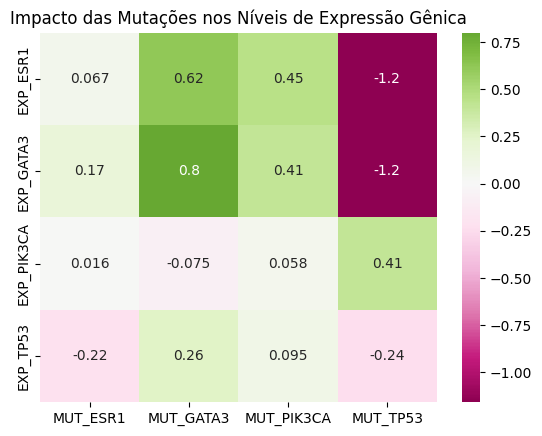

In [ ]:
# @title Cruzamento de toda mutação vs toda expressão

# Cruzamento de toda mutação vs toda expressão
mut_cols = [c for c in df_master.columns if c.startswith('MUT_')]
exp_cols = [c for c in df_master.columns if c.startswith('EXP_')]

assoc_matrix = pd.DataFrame(index=exp_cols, columns=mut_cols)

for mut in mut_cols:
    for exp in exp_cols:
        # Usamos o Teste T ou Mann-Whitney para ver se a expressão muda quando há mutação
        g1 = df_master[df_master[mut] == 1][exp].dropna()
        g0 = df_master[df_master[mut] == 0][exp].dropna()
        if len(g1) > 5 and len(g0) > 5:
            # Calculamos a diferença de médias (Efeito)
            assoc_matrix.loc[exp, mut] = g1.mean() - g0.mean()

sns.heatmap(assoc_matrix.astype(float), annot=True, cmap='PiYG', center=0)
plt.title("Impacto das Mutações nos Níveis de Expressão Gênica")
plt.show()

RISK_GROUP
Baixo Risco    542
Alto Risco     542
Name: count, dtype: int64


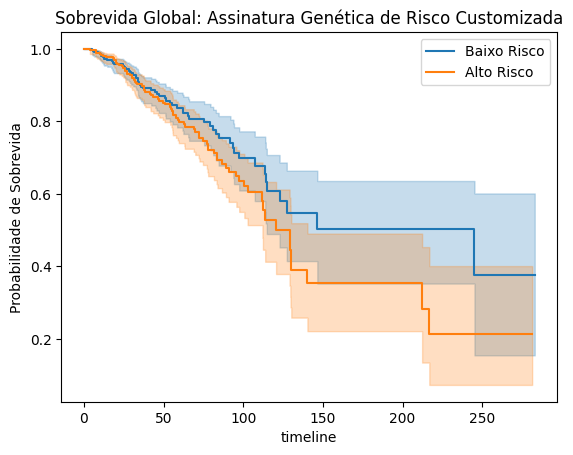

In [ ]:
# @title Hazard Ratio Customizado

# Cálculo do Score (usando preenchimento zero para não perder linhas no cálculo)
df_master['RISK_SCORE'] = (df_master['EXP_TP53'].fillna(0) * 1.5) - (df_master['EXP_ESR1'].fillna(0) * 0.8)

# Solução para o erro do qcut: Usar 'rank' antes de cortar ou definir manualmente
try:
    df_master['RISK_GROUP'] = pd.qcut(df_master['RISK_SCORE'].rank(method='first'), q=2, labels=['Baixo Risco', 'Alto Risco'])
except ValueError:
    # Caso o qcut falhe, usamos a mediana manualmente
    mediana = df_master['RISK_SCORE'].median()
    df_master['RISK_GROUP'] = df_master['RISK_SCORE'].apply(lambda x: 'Alto Risco' if x > mediana else 'Baixo Risco')

# Verificação de quantos pacientes ficaram em cada grupo
print(df_master['RISK_GROUP'].value_counts())

# Plotar a curva final de Kaplan-Meier comparando os dois grupos de Score
from lifelines import KaplanMeierFitter
kmf = KaplanMeierFitter()

for label in df_master['RISK_GROUP'].unique():
    mask = df_master['RISK_GROUP'] == label
    kmf.fit(df_master[mask]['OS_MONTHS'], df_master[mask]['EVENT'], label=label)
    kmf.plot_survival_function()

plt.title("Sobrevida Global: Assinatura Genética de Risco Customizada")
plt.ylabel("Probabilidade de Sobrevida")
plt.show()

# Análises demográficas e clínicas

In [ ]:
df_analise = df_master.copy()

# 1. LIMPEZA CRÍTICA: OS_STATUS
def mapear_status(status):
    if pd.isna(status): return 0
    status = str(status).upper()
    # Verifica se contém termos de óbito ou o número 1
    if 'DECEASED' in status or '1' in status:
        return 1
    return 0

df_analise['EVENT'] = df_analise['OS_STATUS'].apply(mapear_status)

# 2. Simplificar o Estágio (Forma Robusta)
# Dica: Usamos .str.extract para pegar o número romano principal (I, II, III ou IV)
df_analise['STAGE_SIMPLIFICADO'] = (
    df_analise['AJCC_PATHOLOGIC_TUMOR_STAGE']
    .str.extract(r'(STAGE [IVX]+)') # Extrai 'STAGE I', 'STAGE II', etc, ignorando 'A', 'B'
    .fillna('Other/Unknown')        # O que não for STAGE vira 'Other/Unknown'
)

# Se ainda assim quiser filtrar o 'Other/Unknown' dos gráficos:
df_analise = df_analise[df_analise['STAGE_SIMPLIFICADO'] != 'Other/Unknown']

print("\n--- Verificação ---")
print(df_analise['STAGE_SIMPLIFICADO'].value_counts())


--- Verificação ---
STAGE_SIMPLIFICADO
STAGE II     616
STAGE III    249
STAGE I      181
STAGE IV      19
STAGE X       14
Name: count, dtype: int64


/tmp/ipython-input-3574859596.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='STAGE_SIMPLIFICADO', y='OS_MONTHS', data=df_analise, ax=axes[0], palette="Reds")
/tmp/ipython-input-3574859596.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='SUBTYPE', y='OS_MONTHS', data=df_analise, ax=axes[1], palette="Blues")


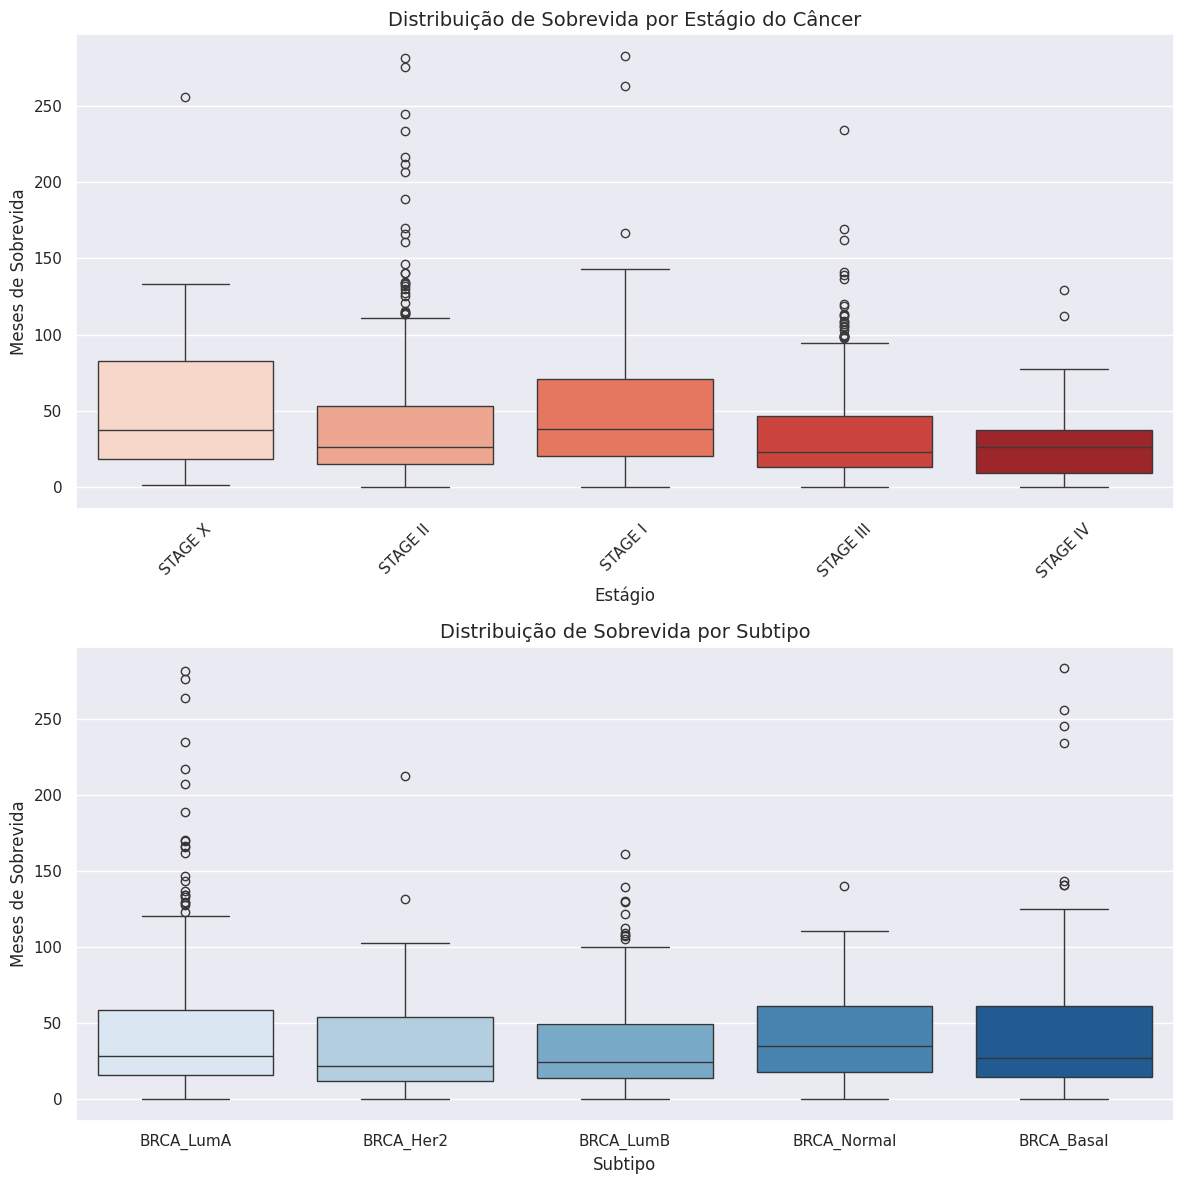

In [ ]:
# @title Boxplots
# Configuração visual
sns.set(style="darkgrid")
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Gráfico 1: Sobrevida por Estágio do Câncer
sns.boxplot(x='STAGE_SIMPLIFICADO', y='OS_MONTHS', data=df_analise, ax=axes[0], palette="Reds")
axes[0].set_title('Distribuição de Sobrevida por Estágio do Câncer', fontsize=14)
axes[0].set_xlabel('Estágio')
axes[0].set_ylabel('Meses de Sobrevida')
axes[0].tick_params(axis='x', rotation=45) # Gira o texto se ficar encavalado

# Gráfico 2: Sobrevida por Subtipo Molecular
if 'SUBTYPE' in df_analise.columns:
    sns.boxplot(x='SUBTYPE', y='OS_MONTHS', data=df_analise, ax=axes[1], palette="Blues")
    axes[1].set_title('Distribuição de Sobrevida por Subtipo', fontsize=14)
    axes[1].set_xlabel('Subtipo')
    axes[1].set_ylabel('Meses de Sobrevida')

plt.tight_layout()
plt.show()

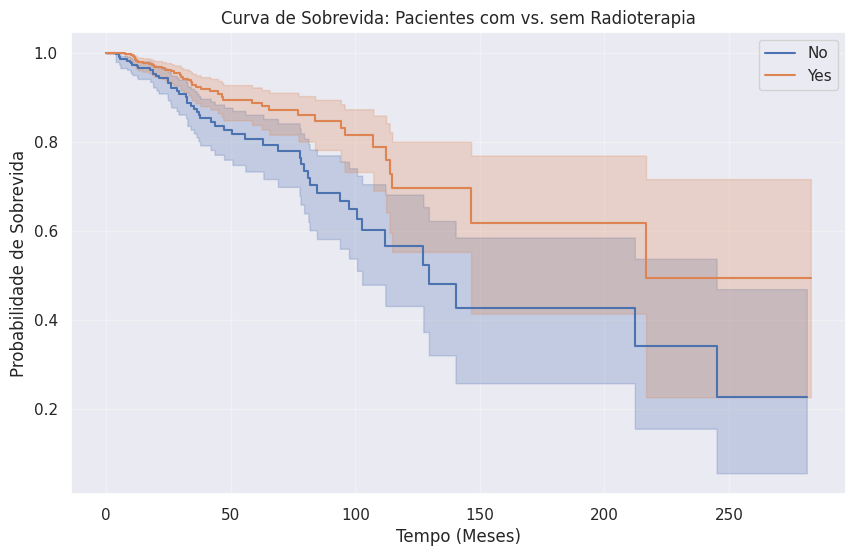

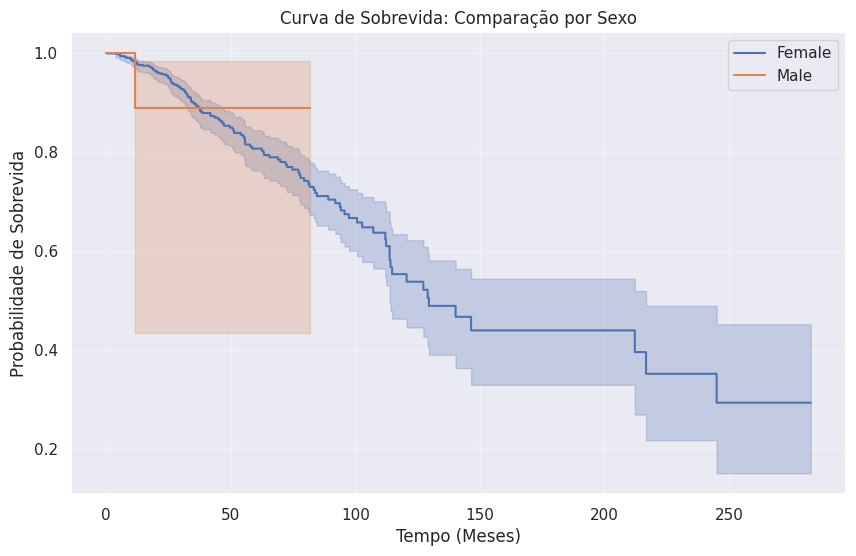

In [ ]:
# @title Curvas de Sobrevida (Kaplan-Meier)

def plotar_km(coluna_analise, titulo):
    kmf = KaplanMeierFitter()
    plt.figure(figsize=(10, 6))

    # Remove nulos dessa coluna específica para não dar erro
    df_temp = df_analise.dropna(subset=[coluna_analise, 'OS_MONTHS', 'EVENT'])

    # Pega todas as categorias únicas (ex: YES, NO)
    categorias = df_temp[coluna_analise].unique()

    for cat in categorias:
        # Filtra os dados daquela categoria
        mask = df_temp[coluna_analise] == cat

        # Ajusta a curva
        kmf.fit(durations=df_temp[mask]['OS_MONTHS'],
                event_observed=df_temp[mask]['EVENT'],
                label=str(cat))

        # Plota
        kmf.plot_survival_function()

    plt.title(f'Curva de Sobrevida: {titulo}')
    plt.ylabel('Probabilidade de Sobrevida')
    plt.xlabel('Tempo (Meses)')
    plt.grid(True, alpha=0.3)
    plt.show()

# 1. Analisar Radioterapia
plotar_km('RADIATION_THERAPY', 'Pacientes com vs. sem Radioterapia')

# 2. Analisar Gênero (se fizer sentido no dataset, BRCA costuma ser maj. feminino)
plotar_km('SEX', 'Comparação por Sexo')

# 3. Analisar Estágio (Simplificado)
# Filtra apenas os estágios principais para o gráfico não ficar poluido
df_analise_stage = df_analise[df_analise['STAGE_SIMPLIFICADO'].isin(['Stage I', 'Stage II', 'Stage III', 'Stage IV'])]

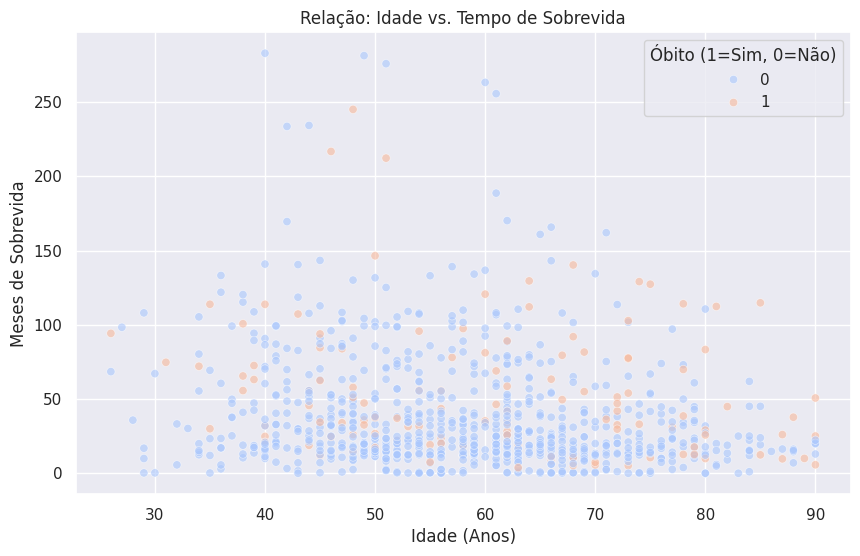

/tmp/ipython-input-2245773408.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='RACE', y='OS_MONTHS', data=df_raca, palette="Set2")


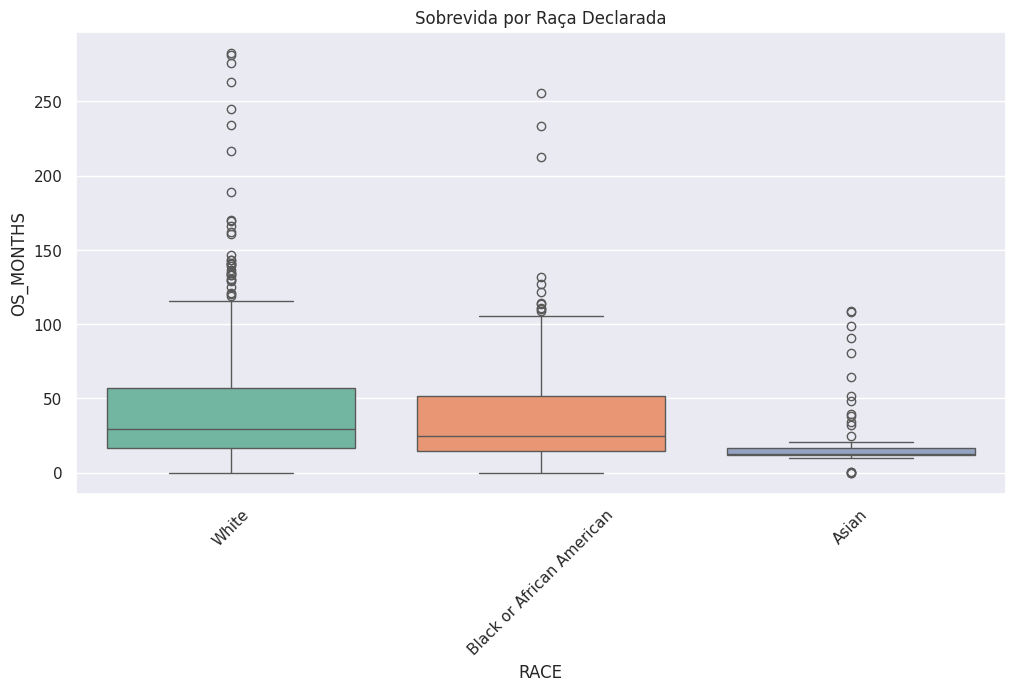

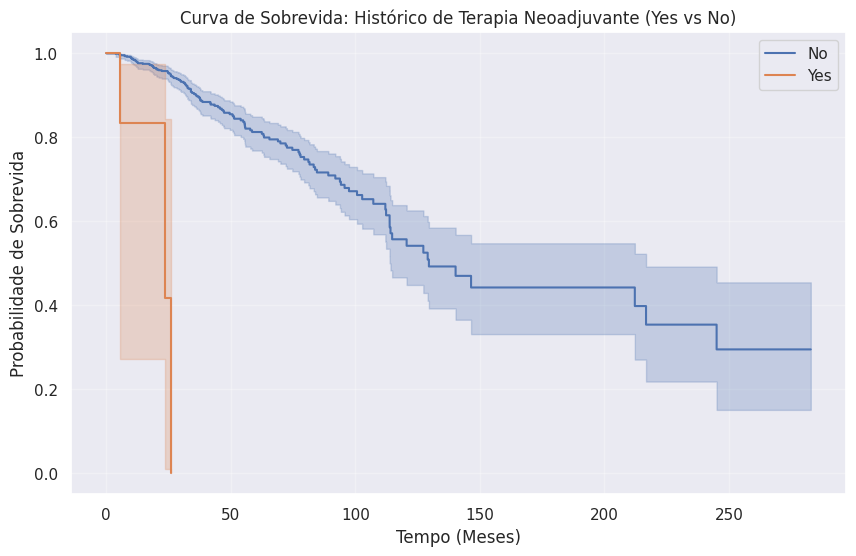

ValueError: List of boxplot statistics and `positions` values must have same the length

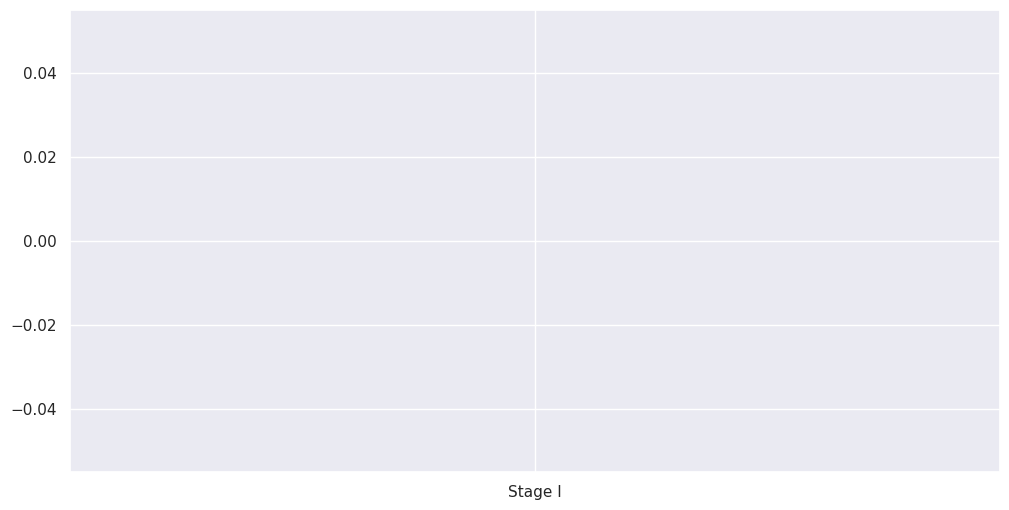

In [ ]:
# --- BLOCO COMPLEMENTAR: DEMOGRAFIA E OUTROS TRATAMENTOS ---

# 1. ANÁLISE DEMOGRÁFICA: IDADE (AGE)
# Vamos ver se a idade influencia na sobrevida usando um Scatter Plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='AGE', y='OS_MONTHS', hue='EVENT', data=df_analise, alpha=0.6, palette='coolwarm')
plt.title('Relação: Idade vs. Tempo de Sobrevida')
plt.xlabel('Idade (Anos)')
plt.ylabel('Meses de Sobrevida')
plt.legend(title='Óbito (1=Sim, 0=Não)')
plt.show()

# 2. ANÁLISE DEMOGRÁFICA: RAÇA/ETNIA (RACE)
# Vamos verificar se existem disparidades raciais na sobrevida
# (Nota: filtraremos 'White' e 'Black or African American' que costumam ser maioria para o gráfico ficar limpo, mas você pode remover o filtro)
principais_racas = df_analise['RACE'].value_counts().nlargest(3).index
df_raca = df_analise[df_analise['RACE'].isin(principais_racas)]

plt.figure(figsize=(12, 6))
sns.boxplot(x='RACE', y='OS_MONTHS', data=df_raca, palette="Set2")
plt.title('Sobrevida por Raça Declarada')
plt.xticks(rotation=45)
plt.show()

# 3. ANÁLISE DE TRATAMENTO 2: Terapia Neoadjuvante
# (Tratamento feito ANTES da cirurgia principal)
# Verifica se a coluna existe e plota a curva de sobrevida
if 'HISTORY_NEOADJUVANT_TRTYN' in df_analise.columns:
    plotar_km('HISTORY_NEOADJUVANT_TRTYN', 'Histórico de Terapia Neoadjuvante (Yes vs No)')

# 4. ANÁLISE CRUZADA: Estágio vs Idade
# Quem descobre o câncer mais tarde? Jovens ou Idosos?
plt.figure(figsize=(12, 6))
sns.boxplot(x='STAGE_SIMPLIFICADO', y='AGE', data=df_analise, order=['Stage I', 'Stage II', 'Stage III', 'Stage IV'])
plt.title('Idade dos Pacientes por Estágio do Câncer')
plt.show()